In [1]:
!pip install pyagrum pydotplus xlrd openpyxl graphviz

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Imports
import os
import numpy as np
import pandas as pd
from pylab import *
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, f1_score, classification_report
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from pyAgrum.lib.bn2roc import showROC
from collections import Counter
from IPython.core.display import display, HTML
import time
import logging
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report, accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
# Some formatting
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 4 decimal points
pd.set_option('display.max_columns', None)

display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

# Path
path = ''

# Functions
def not_found(df,perc=0):  
    m_df = df.isnull().sum().reset_index()  #missing dataframe m_df
    m_df.columns = ['column', 'missing count']
    m_df['percentage']=(m_df['missing count'])/df.shape[0]*100
    m_df = m_df[m_df.percentage>perc]
    return m_df.sort_values(by='percentage',ascending=False) #sorting by percentage

def show_unique(df):
    count = pd.DataFrame()
    count['nunique'] = df.nunique()
    count= count[count['nunique'] == 1]
    return count

def fill_null(dframe, attr_list, stat = 'integer', integer = -1):  #if will fill the null values of columns with mean,median or 
                      # mode. Integer fills the null with -1 (by default)
    for i in attr_list:     
        if stat == 'median':
            dframe[i].fillna(dframe[i].median(), inplace=True) 
        elif stat == 'mode':
            dframe[i].fillna(dframe[i].mode()[0], inplace=True) 
        elif stat == 'mean':
            dframe[i].fillna(dframe[i].mean(), inplace=True)
        elif stat == 'integer':
            dframe[i].fillna(integer, inplace=True) 
    return dframe

def compression_ratio(b):
    return 100*(1-get_cpts_size(b)/ get_jpd_size(b))
  
def get_jpd_size(b):
    return np.prod([b.variable(node).domainSize() for node in b.nodes()])

def get_cpts_size(b):
    return sum([np.prod(b.cpt(node).var_dims) for node in b.nodes() ])  

def post(row,bnetwork,target): #calculate the posterior
        lp = gum.LazyPropagation(bnetwork)
        z = row.astype(str).to_dict()
        #print(z)
        del z[target]
        lp.setEvidence(z)
        lp.addTarget(target)
        return lp.posterior(target).toarray()[1]

#########/////////////////////////////#######

** pyAgrum** For better visualizations, please install matplotlib-inline.


In [3]:
# Wrapper class
class BNEstimator(BaseEstimator, ClassifierMixin): #template for bayesian network
    
    def __init__(self,tabu_arcs=[],cls_name = None,csv_temp=None,bn=None,lr_method='greedy',compulsory_arcs=[],
               prior='likelihood', threshold = .5,nb_classes = 2,prior_wt=.5, positif_label = None,               
               cut_percentiles  = list(100*np.linspace(0, 1,5)),bins=5):
        
        
        self.csv_temp = csv_temp
        self.compulsory_arcs = compulsory_arcs
        self.tabu_arcs = tabu_arcs
        self.cls_name = cls_name
        self.lr_method = lr_method
        self.prior = prior
        self.prior_wt = prior_wt
        self.positif_label = positif_label
        self.threshold = threshold
        self.nb_classes = nb_classes
        self.cut_percentiles = cut_percentiles
        self.bins = bins
        self.bnetwork = bn
     
    def get_params(self, deep=True):
        return {"csv_temp":self.csv_temp,# template for modalities
              "cls_name":self.cls_name,
              "prior": self.prior,
              "prior_wt":  self.prior_wt,
              "cls_name"  :self.cls_name ,
              "positif_label"  :self.positif_label ,
              "threshold" : self.threshold ,
              "nb_classes"  :self.nb_classes ,
              "compulsory_arcs": self.compulsory_arcs,
              "tabu_arcs":self.tabu_arcs,
              "lr_method": self.lr_method, 
              "cut_percentiles"  :self.cut_percentiles,
              "bins" : self.bins}
    
    def set_params(self, **param):
        for param, value in param.items():
            setattr(self, param, value)
        return self

    def transform(self,dframe): #transform whole daa
        
        temp = gum.BayesNet() #template
        num_cols = list(dframe.select_dtypes(include=[np.number]).columns)
        categ_cols = list(dframe.select_dtypes(include=[object]).columns)
        for col in num_cols:
            if dframe[col].value_counts().shape[0]>self.bins:
                x = dframe[col].values.flatten()
                x.sort()
                cut_points = np.percentile(x, self.cut_percentiles)
                dframe.loc[:,col]= np.digitize(x, cut_points, right=False)   
                del x
            temp.add(gum.LabelizedVariable(col,col,list(map(str,dframe[col].value_counts().index)))) 
        
        for col in categ_cols:
            if dframe[col].value_counts().shape[0]>self.bins:
                top = dframe[col].isin(dframe[col].value_counts().index[:self.bins])
                dframe.loc[~top, col] = "else_top_"+str(self.bins)

                del top
            temp.add(gum.LabelizedVariable(col,col,list(map(str,dframe[col].value_counts().index))))
        
        return temp,dframe 
        
    def fit(self,data,y=None):
        
        temp,_ = self.transform(pd.read_csv(self.csv_temp))
        _,train= self.transform(data)
                
        train.to_csv('train_bn.csv',index=False)
        blearner = gum.BNLearner('train_bn.csv', temp)
        
        for j in self.tabu_arcs: blearner.addForbiddenArc(j[0],j[1])
        for j in self.compulsory_arcs :  blearner.addMandatoryArc(j[0],j[1])

        if self.lr_method == 'greedy':blearner.useGreedyHillClimbing()
        else: blearner.useMIIC()

        if self.prior == "laplace":blearner.useAprioriSmoothing(self.prior_wt)
        else:blearner.useNoApriori()    
        
        self.bnetwork = blearner.learnBN()
        self.bnetwork = blearner.learnParameters(self.bnetwork.dag())        
        del temp,train
        return self

    def predict_one_row(self,r):
        ie = gum.LazyPropagation(self.bnetwork)
        ie.addTarget(self.cls_name) 
        
        evs = r.astype(str).to_dict()
        del evs[self.cls_name]      
        ie.setEvidence(evs)
        ie.makeInference()
        return ie.posterior(self.cls_name).toarray()

    def predict_proba(self, X_test):
        if type(X_test) is np.ndarray:
            X_test = pd.DataFrame(X_test, columns=["X{}".format(i) for i in range(X_test.shape[1])])

        Y_score = np.empty([X_test.shape[0], self.nb_classes])
        Y_score[:] = np.nan

        mb_names = [self.bnetwork.variable(j).name()
                   for j in gum.MarkovBlanket(self.bn, self.cls_name).nodes()
                   if self.bnetwork.variable(j).name() != self.cls_name]
        lp = gum.LazyPropagation(self.bnetwork)
        for name in ie.BN().names():  
            if name != self.cls_name:
                lp.addEvidence(name, 0)
        lp.addTarget(self.cls_name)
        X_test = X_test.reset_index(drop=True)
        
        for line in X_test.itertuples():
            for name in mb_names:
                try:
                    idx = self.bn.variable(name).index(str(getattr(line, name)))
                    ie.chgEvidence(name, idx)
                except gum.GumException:
                     pass

            ie.makeInference()

            marg = ie.posterior(self.cls_name)
            Y_score[line[0]] = marg.toarray()
        return Y_score
        
    def predict(self,test):
        y_scores = self.predict_proba(test)[:,1]
        y_true = test[self.cls_name]
        
        return y_true, np.where(y_scores >= self.threshold, 1, 0)

    def score(self,test):
        ytrue,ypred = self.predict(test)
        print(classification_report(ytrue, ypred))
        print(6*'--')
        print('Recall Sroce')
        return recall_score(ytrue, ypred)

In [4]:
path=''

In [5]:
df = pd.read_excel('DataSet/dataset.xlsx',engine='openpyxl')

dframe = df.copy()

In [6]:
dframe.rename(columns= {
                    'Patient addmited to semi-intensive unit (1=yes, 0=no)': 'semi_intensive_care',
                   'Patient addmited to intensive care unit (1=yes, 0=no)': 'intensive_care',
                   'Influenza B, rapid test': 'Influenza B rapid test',
                   'Patient addmited to regular ward (1=yes, 0=no)': 'regular_ward',
                   'SARS-Cov-2 exam result': 'covid_19', 
                   'Influenza A, rapid test': 'Influenza A rapid test'}, inplace = True)

dframe['covid_19'] = dframe['covid_19'].apply(lambda x :1 if x=='positive' else 0)
dframe.drop(columns = 'Patient ID', inplace = True) #patient id is not required at all, so droping

In [7]:
dframe.drop(columns = list(not_found(dframe, perc = 95).column.values), inplace = True)
dframe.drop(columns = list(show_unique(dframe).index), inplace = True)

In [8]:
kept_cols = [d for d in dframe if dframe[d].nunique()<=4]
kept_cols.extend(['Platelets','Red blood Cells','Lymphocytes','Leukocytes'])
t=kept_cols,len(kept_cols)

In [9]:
t=not_found(df)

In [10]:
dframe = dframe[kept_cols]
t= not_found(dframe)

In [11]:
continuous_cols = [x for x in dframe.columns if dframe[x].dtypes == 'float64']
discrete_cols = [x for x in dframe.columns if (dframe[x].dtypes == 'int64') | (dframe[x].dtypes == 'O')]
for i in ['covid_19','intensive_care','regular_ward', 'semi_intensive_care',]:
    discrete_cols.remove(i)  # Drop targets

dframe = fill_null(dframe, continuous_cols, stat = 'median')
dframe = fill_null(dframe, discrete_cols, stat = 'integer', integer = '-1')

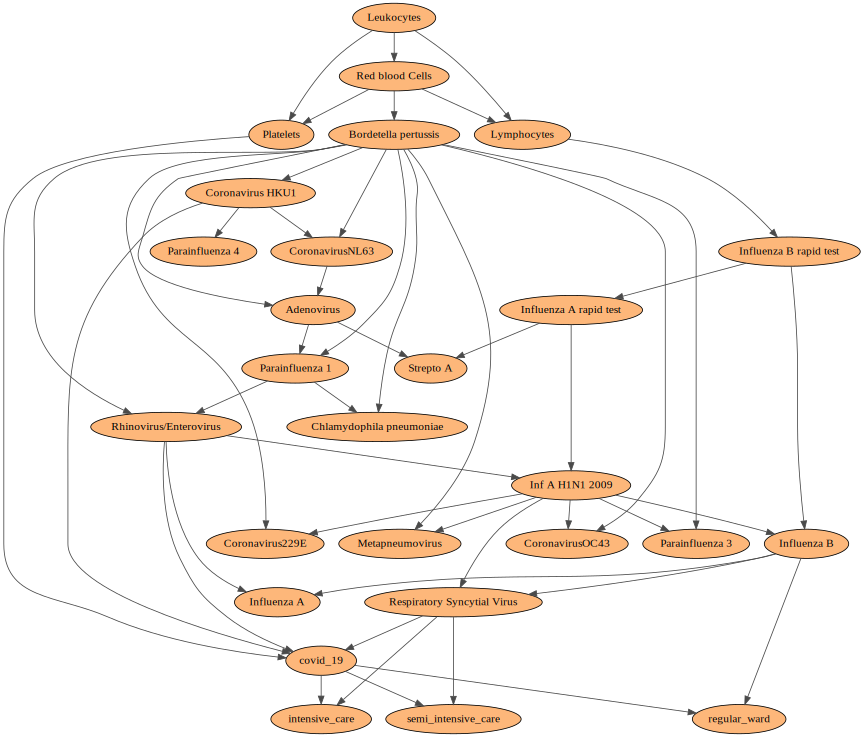

In [12]:
dframe.to_csv(path + 'template.csv', index = False)
clf = BNEstimator(csv_temp=path+'template.csv', cls_name='covid_19',
                  tabu_arcs=[('Influenza B rapid test', 'covid_19')],
                  compulsory_arcs=[('Coronavirus HKU1','covid_19'),('Respiratory Syncytial Virus','covid_19'),
                                  ('covid_19','intensive_care'),('covid_19','semi_intensive_care'),('covid_19','regular_ward')],
                  cut_percentiles = [5, 50, 95])
_,data = clf.transform(dframe)
train,test = train_test_split(data ,test_size=0.26, random_state=42)
train.to_csv(path +'train.csv',index=False)
test.to_csv(path +'test.csv',index=False)
clf.fit(train)
gnb.showBN(clf.bnetwork,size=12,nodeColor={n:0.66 for n in clf.bnetwork.names()},cmap=plt.cm.get_cmap('Oranges_r'))

In [13]:
clf.bnetwork.cpt(clf.bnetwork.idFromName('regular_ward'))

(gum::Potential<double>@0x17a6810) 
             ||  regular_ward     |
Influe|covid_||0        |1        |
------|------||---------|---------|
-1    |0     || 0.9975  | 0.0025  |
not_de|0     || 0.9713  | 0.0287  |
detect|0     || 0.9983  | 0.0017  |
-1    |1     || 0.9822  | 0.0178  |
not_de|1     || 0.7495  | 0.2505  |
detect|1     || 0.9286  | 0.0714  |

In [14]:
gum.MarkovBlanket(clf.bnetwork,'regular_ward')

<pyAgrum.pyAgrum.MarkovBlanket; proxy of <Swig Object of type 'gum::MarkovBlanket *' at 0x7f9799b1c1b0> >

** pyAgrum** For better visualizations, please install matplotlib-inline.


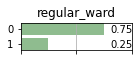

In [15]:
gnb.showPosterior(clf.bnetwork, evs={
                  'Platelets':'3',
                  'Red blood Cells':'3',
                  'Bordetella pertussis':'detected',
                  'Respiratory Syncytial Virus': 'detected',
                  'covid_19':'1'
                  },
                 target='regular_ward')

In [16]:
clf.bnetwork.cpt(clf.bnetwork.idFromName('intensive_care'))

(gum::Potential<double>@0x20c65c0) 
             ||  intensive_care   |
Respir|covid_||0        |1        |
------|------||---------|---------|
-1    |0     || 0.9989  | 0.0011  |
not_de|0     || 0.9851  | 0.0149  |
detect|0     || 0.8396  | 0.1604  |
-1    |1     || 0.9939  | 0.0061  |
not_de|1     || 0.9620  | 0.0380  |
detect|1     || 0.5000  | 0.5000  |

In [17]:
gum.MarkovBlanket(clf.bnetwork,'intensive_care')

<pyAgrum.pyAgrum.MarkovBlanket; proxy of <Swig Object of type 'gum::MarkovBlanket *' at 0x7f97aea756f0> >

** pyAgrum** For better visualizations, please install matplotlib-inline.


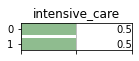

In [18]:
gnb.showPosterior(clf.bnetwork, evs={
                  'Platelets':'3',
                  'Red blood Cells':'3',
                  'Bordetella pertussis':'detected',
                  'Respiratory Syncytial Virus': 'detected',
                  'covid_19':'1'
                  },
                 target='intensive_care')

** pyAgrum** For better visualizations, please install matplotlib-inline.


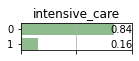

In [19]:
gnb.showPosterior(clf.bnetwork, evs={
                  'Platelets':'3',
                  'Red blood Cells':'3',
                  'Bordetella pertussis':'detected',
                  'Respiratory Syncytial Virus': 'detected',
                  'covid_19':'0'
                  },
                 target='intensive_care')

In [20]:
clf.bnetwork.cpt(clf.bnetwork.idFromName('semi_intensive_care'))

(gum::Potential<double>@0x11e9940) 
             ||  semi_intensive_ca|
covid_|Respir||0        |1        |
------|------||---------|---------|
0     |-1    || 0.9978  | 0.0022  |
1     |-1    || 0.9968  | 0.0032  |
0     |not_de|| 0.9783  | 0.0217  |
1     |not_de|| 0.9620  | 0.0380  |
0     |detect|| 0.8623  | 0.1377  |
1     |detect|| 0.5000  | 0.5000  |

In [21]:
gum.MarkovBlanket(clf.bnetwork,'semi_intensive_care')

<pyAgrum.pyAgrum.MarkovBlanket; proxy of <Swig Object of type 'gum::MarkovBlanket *' at 0x7f97ae954210> >

** pyAgrum** For better visualizations, please install matplotlib-inline.


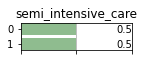

In [22]:
gnb.showPosterior(clf.bnetwork, evs={
                  'Platelets':'3',
                  'Red blood Cells':'3',
                  'Bordetella pertussis':'detected',
                  'Respiratory Syncytial Virus': 'detected',
                  'covid_19':'1'
                  },
                 target='semi_intensive_care')

** pyAgrum** For better visualizations, please install matplotlib-inline.


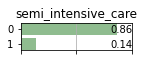

In [23]:
gnb.showPosterior(clf.bnetwork, evs={
                  'Platelets':'3',
                  'Red blood Cells':'3',
                  'Bordetella pertussis':'detected',
                  'Respiratory Syncytial Virus': 'detected',
                  'covid_19':'0'
                  },
                 target='semi_intensive_care')

In [24]:
clf.bnetwork.cpt(clf.bnetwork.idFromName('covid_19'))

(gum::Potential<double>@0x2dd0ea0) 
                           ||  covid_19         |
Corona|Rhinov|Platel|Respir||0        |1        |
------|------|------|------||---------|---------|
-1    |-1    |2     |-1    || 0.9078  | 0.0922  |
not_de|-1    |2     |-1    || 0.5000  | 0.5000  |
detect|-1    |2     |-1    || 0.5000  | 0.5000  |
-1    |not_de|2     |-1    || 0.5000  | 0.5000  |
not_de|not_de|2     |-1    || 0.5000  | 0.5000  |
detect|not_de|2     |-1    || 0.5000  | 0.5000  |
[...96 more line(s) ...]
-1    |not_de|1     |detect|| 0.5000  | 0.5000  |
not_de|not_de|1     |detect|| 0.5000  | 0.5000  |
detect|not_de|1     |detect|| 0.5000  | 0.5000  |
-1    |detect|1     |detect|| 0.5000  | 0.5000  |
not_de|detect|1     |detect|| 0.5000  | 0.5000  |
detect|detect|1     |detect|| 0.5000  | 0.5000  |

In [25]:
gum.MarkovBlanket(clf.bnetwork,'covid_19')

<pyAgrum.pyAgrum.MarkovBlanket; proxy of <Swig Object of type 'gum::MarkovBlanket *' at 0x7f97f7da1e70> >

** pyAgrum** For better visualizations, please install matplotlib-inline.


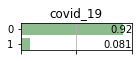

In [26]:
gnb.showPosterior(clf.bnetwork, evs={
                  'Platelets':'3',
                  'Red blood Cells':'3',
                  'Bordetella pertussis':'detected',
                  'Respiratory Syncytial Virus': 'detected',
                  },
                 target='covid_19')

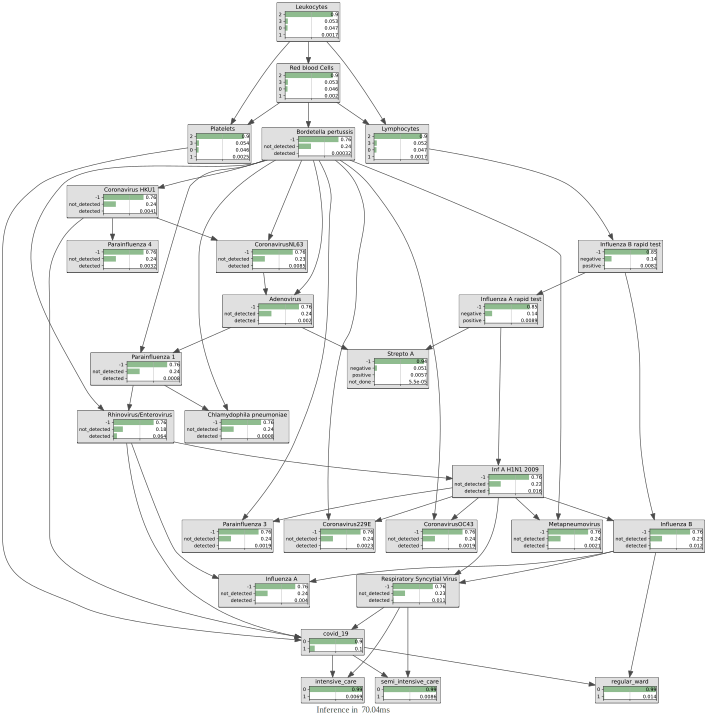

In [27]:
gnb.showInference(clf.bnetwork,size=10)

** pyAgrum** For better visualizations, please install matplotlib-inline.


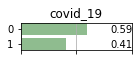

In [28]:
gnb.showPosterior(clf.bnetwork, evs={'Platelets':'3', 'Influenza B':'detected', 'Coronavirus HKU1':'not_detected'},
                 target='covid_19')# we specify the target we want to analyse

In [29]:
gum.MarkovBlanket(clf.bnetwork,'covid_19')

<pyAgrum.pyAgrum.MarkovBlanket; proxy of <Swig Object of type 'gum::MarkovBlanket *' at 0x7f97ae117600> >

** pyAgrum** For better visualizations, please install matplotlib-inline.


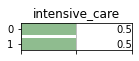

In [30]:
d_test = pd.read_csv(path + 'test.csv')
row = d_test.loc[1,:]
evs = row.astype(str).to_dict()

evidence = { 'Platelets':'3',
                  'Red blood Cells':'3',
                  'Bordetella pertussis':'detected',
                  'Respiratory Syncytial Virus': 'detected',
                  'covid_19':'1',

           }
gnb.showPosterior(clf.bnetwork,
                 target='intensive_care',
                 evs=evidence)

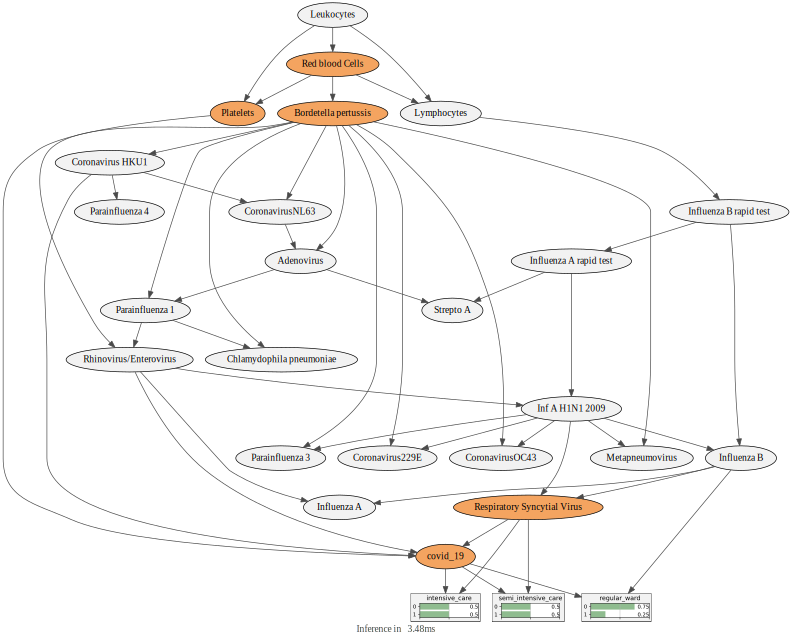

In [31]:
MB = gum.MarkovBlanket(clf.bnetwork,'covid_19')

gnb.showInference(clf.bnetwork, 
                  nodeColor={n:0.9 for n in clf.bnetwork.names()},
                  evs=evidence,
                  targets={'intensive_care','semi_intensive_care','regular_ward'},
                  size=11)